# Classifying CIFAR-10 Using ResNet-152 with and without Fine-Tunining

In this project, we will use ResNet-152 [1] to classify the CIFAR-10 dataset [2], both with and without fine-tuning the model.


Deeper neural networks are more difficult to train. ResNets present a residual learning framework to ease the training of networks that were substantially deeper than those that had been used before the time of publication of "Deep Residual Learning for Image Recognition", which is 2015. ResNets explicitly reformulates the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. ResNet-152 is one of these ResNets.

ResNets were evaluated on the ImageNet dataset. ResNets had a depth of of upto 152 layers, which is 8 times deeper than VGG nets but having lower complexity. An ensemble of these ResNets achieves 3.57% error on the ImageNet test set. This result won the 1st place ont he ILSVRC 2015 classification task.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5,000 images from each class.

We will start this project by loading the CIFAR-10 dataset into train, validation, and test DataLoaders. Then, we will instantiate ResNet-152 and freeze the entire model. We will modify the final layer of the model for the classification of CIFAR-10, and unfreeze only this layer. This will be followed by training the model for 30 epochs. This will also involve plotting the training and validation losses against the number of epochs, and the validation accuracy against the number of epochs. These plots will be inspected to identify the optimum number of epochs. The model will then be instatiated again and trained on CIFAR-10 for the optimal number of epochs before being evaluated on the test set.

Once all this has been done, we will repeat the whole process again, only this time, we will leave all the layers in the model unfrozen to allow for fine-tuning.

## Importing the Required Packages

We will first import the required packages.

In [ ]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt

## Preparing the Data

We will define the transformations for the data.

In [ ]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

We will load the data into variables.

In [ ]:
full_train_data = torchvision.datasets.CIFAR10(
    root = "/content/data",
    train = True,
    download = True,
    transform = transforms)

test_data = torchvision.datasets.CIFAR10(
    root = "/content/data",
    train = False,
    download = True,
    transform = transforms)

Splitting the full training data into training and validation sets.

In [ ]:
train_size = int(0.8 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, validation_data = random_split(full_train_data, [train_size, val_size])

Creating the DataLoaders.

In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

## Setting the Device

We will set the device to the GPU if it is available, or the CPU if the GPU isn't available.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Classification without Fine-Tuning

We will load the pre-trained ResNet-152 model and freeze all its layers. Then, we will modify its final layer such that it suitable for classifying the CIFAR-10 data into 10 classes. We will then unfreeze only this final layer as it is completely untrained. We then move the model to the GPU. Finally, we instantiate the loss criterion and the optimizer.

In [ ]:
# Instantiating the model
model = models.resnet152(pretrained=True)

# Freezing the entire model
for param in model.parameters():
  param.requires_grad = False

# Modifying the final layer
model.fc = nn.Linear(model.fc.in_features, 10)

# Unfreezing the final layer
for param in model.fc.parameters():
  param.requires_grad = True

model = model.to(device)

loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We will create a function to run the training and validation loops, and plot the results.

In [ ]:
def train_model_and_plot(model,
                num_epochs,
                train_loader,
                validation_loader,
                plot=True):

  train_losses = []
  validation_losses = []
  validation_accuracies = []

  # Running the training and validation loops

  for epoch in range(num_epochs):

    # Training phase

    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = loss_criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    # Calculating the average training loss
    train_loss /= len(train_loader)

    # Validation phase

    model.eval()
    validation_loss = 0.0
    correct_predictions = 0
    total_labels = 0

    with torch.no_grad():
      for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_criterion(outputs, labels)
        validation_loss += loss.item()
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_labels += labels.size(0)

    # Calculating the average validation loss and
    # the average validation accuracy
    validation_loss /= len(validation_loader)
    validation_accuracy = 100 * (correct_predictions / total_labels)

    # Storing the training loss, the validation loss,
    # and the validation accuracy
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}")
    print(f"Validation Accuracy: {validation_accuracy:.2f}%")
    print("\n")

  # Creating the plots

  if plot == True:

    epochs = range(1, (num_epochs+1))

    # Plotting the losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses versus Number of Epochs")
    plt.legend()
    plt.show()

    # Plotting the accuracies
    plt.figure()
    plt.plot(epochs, validation_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy/%")
    plt.title("Validation Accuracy versus Number of Epochs")
    plt.legend()
    plt.show()

We will create a function to evaluate the model on the test data.

In [ ]:
def evaluate_model(model, test_loader):

  model.eval()
  correct_predictions = 0
  total_predictions = 0

  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted_labels = torch.max(outputs, 1)
      correct_predictions += (predicted_labels == labels).sum().item()
      total_predictions += labels.size(0)

  test_accuracy = 100 * (correct_predictions / total_predictions)

  print(f"Test Accuracy: {test_accuracy:.2f}%")

We will train the model now and plot the results.

Epoch 1/30
Training Loss: 0.7447
Validation Loss: 0.5387
Validation Accuracy: 81.74%


Epoch 2/30
Training Loss: 0.5146
Validation Loss: 0.5048
Validation Accuracy: 82.84%


Epoch 3/30
Training Loss: 0.4813
Validation Loss: 0.4804
Validation Accuracy: 83.63%


Epoch 4/30
Training Loss: 0.4615
Validation Loss: 0.4808
Validation Accuracy: 83.48%


Epoch 5/30
Training Loss: 0.4545
Validation Loss: 0.4726
Validation Accuracy: 83.70%


Epoch 6/30
Training Loss: 0.4412
Validation Loss: 0.4821
Validation Accuracy: 83.81%


Epoch 7/30
Training Loss: 0.4302
Validation Loss: 0.4551
Validation Accuracy: 84.31%


Epoch 8/30
Training Loss: 0.4273
Validation Loss: 0.4651
Validation Accuracy: 83.93%


Epoch 9/30
Training Loss: 0.4211
Validation Loss: 0.4675
Validation Accuracy: 84.05%


Epoch 10/30
Training Loss: 0.4168
Validation Loss: 0.4659
Validation Accuracy: 84.10%


Epoch 11/30
Training Loss: 0.4055
Validation Loss: 0.4420
Validation Accuracy: 84.53%


Epoch 12/30
Training Loss: 0.4015
Validat

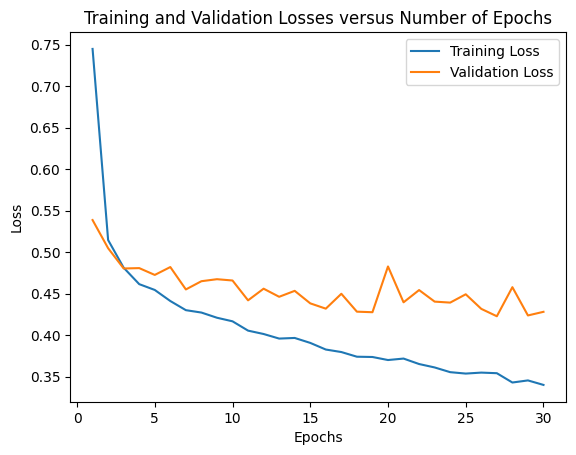

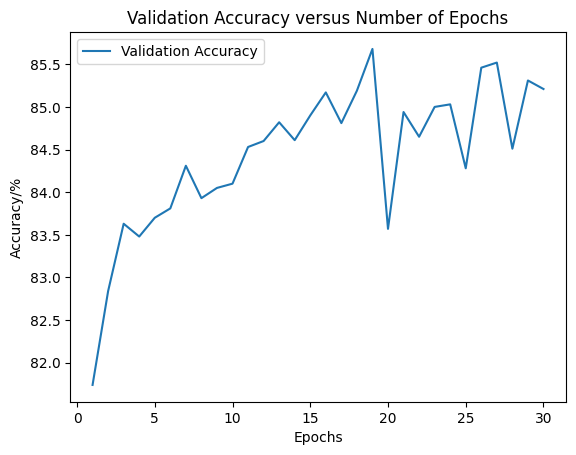

In [ ]:
train_model_and_plot(model = model,
        num_epochs = 30,
        train_loader = train_loader,
        validation_loader = validation_loader,
        plot=True)

Examining the plots show us that at 19 epochs, the validation loss is very close to the minimum and the validation accuracy is at a maximum. So, we can assume that 19 epochs is the optimum number of epochs to train our model for. Choosing a number of epochs where the validation loss is slightly lower and the validation accuracy very close to the maximum would also mean the training loss being much lower, e.g. at 27 epochs and 29 epochs. This makes overfitting more likely. Therefore, we will instantiate our model, optimizer, and loss criterion again, and train the model for 19 epochs before testing its accuracy on the test data.

In [ ]:
# Instantiating the model
model = models.resnet152(pretrained=True)

# Freezing the entire model
for param in model.parameters():
  param.requires_grad = False

# Modifying the final layer
model.fc = nn.Linear(model.fc.in_features, 10)

# Unfreezing the final layer
for param in model.fc.parameters():
  param.requires_grad = True

model = model.to(device)

loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_model_and_plot(model = model,
        num_epochs = 19,
        train_loader = train_loader,
        validation_loader = validation_loader,
        plot=False)

Epoch 1/19
Training Loss: 0.7347
Validation Loss: 0.5307
Validation Accuracy: 82.22%


Epoch 2/19
Training Loss: 0.5162
Validation Loss: 0.4951
Validation Accuracy: 83.05%


Epoch 3/19
Training Loss: 0.4831
Validation Loss: 0.4865
Validation Accuracy: 83.47%


Epoch 4/19
Training Loss: 0.4636
Validation Loss: 0.4944
Validation Accuracy: 83.35%


Epoch 5/19
Training Loss: 0.4533
Validation Loss: 0.4825
Validation Accuracy: 83.53%


Epoch 6/19
Training Loss: 0.4443
Validation Loss: 0.4781
Validation Accuracy: 83.44%


Epoch 7/19
Training Loss: 0.4338
Validation Loss: 0.5075
Validation Accuracy: 82.77%


Epoch 8/19
Training Loss: 0.4240
Validation Loss: 0.4621
Validation Accuracy: 84.18%


Epoch 9/19
Training Loss: 0.4196
Validation Loss: 0.4847
Validation Accuracy: 83.19%


Epoch 10/19
Training Loss: 0.4152
Validation Loss: 0.4557
Validation Accuracy: 84.64%


Epoch 11/19
Training Loss: 0.4047
Validation Loss: 0.4335
Validation Accuracy: 85.08%


Epoch 12/19
Training Loss: 0.4030
Validat

In [ ]:
evaluate_model(model = model, test_loader = test_loader)

Test Accuracy: 85.50%


The model with no fine-tuning achieves an accuracy of 85.50% on the test set.

## Classification with Fine-Tuning

We will load the pre-trained ResNet-152 model and unfreeze all its layers. Then, we will modify its final layer such that it is suitable for classifying the CIFAR-10 data into 10 classes. We will then unfreeze the final layer too. We then move the model to the GPU. Finally, we instantiate the loss criterion and the optimizer.

In [ ]:
# Instantiating the model
model = models.resnet152(pretrained=True)

# Unfreezing the entire model
for param in model.parameters():
  param.requires_grad = True

# Modifying the final layer
model.fc = nn.Linear(model.fc.in_features, 10)

# Unfreezing the final layer
for param in model.fc.parameters():
  param.requires_grad = True

model = model.to(device)

loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

We will train the model now and plot the results.

Epoch 1/30
Training Loss: 0.7234
Validation Loss: 0.6716
Validation Accuracy: 77.21%


Epoch 2/30
Training Loss: 0.3983
Validation Loss: 0.5059
Validation Accuracy: 83.08%


Epoch 3/30
Training Loss: 0.3083
Validation Loss: 0.4711
Validation Accuracy: 84.64%


Epoch 4/30
Training Loss: 0.2306
Validation Loss: 0.4838
Validation Accuracy: 84.90%


Epoch 5/30
Training Loss: 0.1769
Validation Loss: 0.3887
Validation Accuracy: 88.27%


Epoch 6/30
Training Loss: 0.1400
Validation Loss: 0.4167
Validation Accuracy: 87.63%


Epoch 7/30
Training Loss: 0.1169
Validation Loss: 0.3575
Validation Accuracy: 88.53%


Epoch 8/30
Training Loss: 0.0934
Validation Loss: 0.4117
Validation Accuracy: 88.47%


Epoch 9/30
Training Loss: 0.0916
Validation Loss: 0.4571
Validation Accuracy: 87.41%


Epoch 10/30
Training Loss: 0.0676
Validation Loss: 0.4338
Validation Accuracy: 88.14%


Epoch 11/30
Training Loss: 0.0724
Validation Loss: 0.4572
Validation Accuracy: 88.05%


Epoch 12/30
Training Loss: 0.0604
Validat

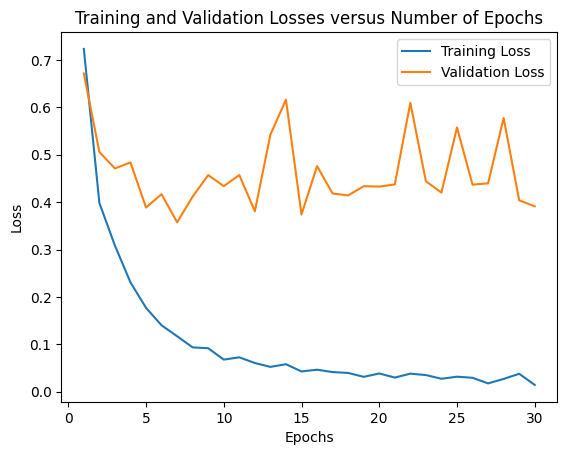

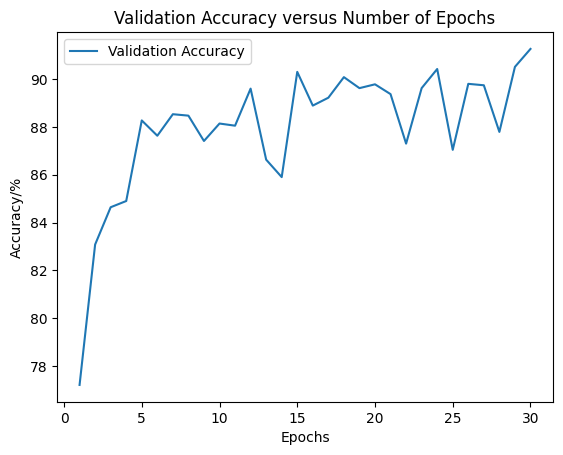

In [ ]:
train_model_and_plot(model = model,
        num_epochs = 30,
        train_loader = train_loader,
        validation_loader = validation_loader,
        plot=True)

Examining the plots show us that at 7 epochs, the validation loss is the least and the validation accuracy is quite high. So, we can assume that 7 epochs is the optimum number of epochs to train our model for. Choosing a number of epochs where the validation loss is slightly higher and the validation accuracy at a maximum would mean choosing 30 epochs. But at 30 epochs, the training loss is the least, indicating probable overfitting. Therefore, we will instantiate our model, optimizer, and loss criterion again, and train the model for 7 epochs before testing its accuracy on the test data.

In [ ]:
# Instantiating the model
model = models.resnet152(pretrained=True)

# Unfreezing the entire model
for param in model.parameters():
  param.requires_grad = True

# Modifying the final layer
model.fc = nn.Linear(model.fc.in_features, 10)

# Unfreezing the final layer
for param in model.fc.parameters():
  param.requires_grad = True

model = model.to(device)

loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_model_and_plot(model = model,
        num_epochs = 7,
        train_loader = train_loader,
        validation_loader = validation_loader,
        plot=False)

Epoch 1/7
Training Loss: 0.7255
Validation Loss: 0.7032
Validation Accuracy: 76.92%


Epoch 2/7
Training Loss: 0.4174
Validation Loss: 0.4722
Validation Accuracy: 83.87%


Epoch 3/7
Training Loss: 0.3042
Validation Loss: 0.3781
Validation Accuracy: 86.94%


Epoch 4/7
Training Loss: 0.2349
Validation Loss: 0.3736
Validation Accuracy: 87.55%


Epoch 5/7
Training Loss: 0.1799
Validation Loss: 0.4351
Validation Accuracy: 86.38%


Epoch 6/7
Training Loss: 0.1601
Validation Loss: 0.3774
Validation Accuracy: 87.71%


Epoch 7/7
Training Loss: 0.1160
Validation Loss: 0.4761
Validation Accuracy: 85.82%




In [ ]:
evaluate_model(model = model, test_loader = test_loader)

Test Accuracy: 85.83%


The model with fine-tuning achieves an accuracy of 89.01% on the test set.

## Results

The model with no fine-tuning achieved an accuracy of 85.50% on the test set while the model with fine-tuning achieved an accuracy of 85.83% on the test set, indicating that one did not perform significantly than another. To attempt to increase the accuracy of the model on the test set, we can next try to unfreeze a combination of layers, which will always include the final layer, and freeze the rest of the layers during training/ We can then repeat the training process, changing this combination everytime.

## References

    [1] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition.” [Online]. Available: http://image-net.org/challenges/LSVRC/2015/


    [2] A. Krizhevsky, V. Nair, G. Hinton. Accessed: Jun. 13, 2025. [Online]. Available: https://www.cs.toronto.edu/~kriz/cifar.html